### **Style Transfer Algorithm**

In [26]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b

In [27]:
StylePath = '/content/input'
ContentPath = '/content/input'

## Loading the path for Base Content Image and the Style image

In [28]:
base_image_path = '/content/input/avatar.jpg'
style_image_path = '/content/input/art2.webp'

In [29]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## This function is used to Preprocess the image with help of VGG19.


In [30]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

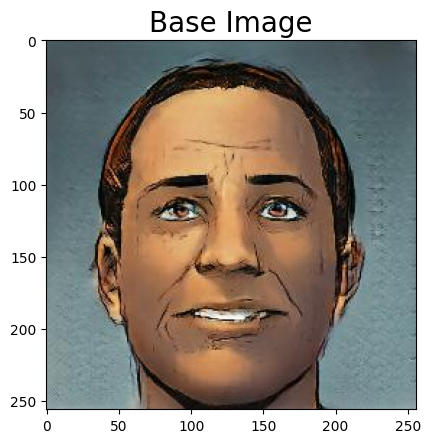

In [31]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(base_image_path)
plt.imshow(img1)

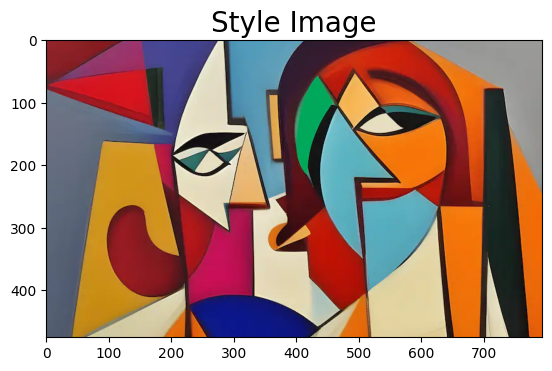

In [32]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(style_image_path)
plt.imshow(img1)

In [33]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

In [34]:
K.image_data_format()

'channels_last'

In [35]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [36]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

## Building the VGG19 model

In [37]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
from keras.applications.vgg19 import VGG19
vgg19_weights = '/content/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')


Model loaded.


Athough Vgg19 is basically used for Classification purpose, but here our objective is not to classify rather our objective is to transform a image, so we do not need all the layers of vgg19, we have specially excluded those layers which are used for classification.

In [38]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2']

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [39]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

Tensor("block5_conv2/Relu:0", shape=(3, 25, 25, 512), dtype=float32)


In [40]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

In [41]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [42]:
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    #if K.image_data_format() == 'channels_first':
    #    features = K.batch_flatten(input_tensor)
    #else:
    #    features = K.batch_flatten(K.permute_dimensions(input_tensor,(2,0,1)))
    #gram = K.dot(features, K.transpose(features))
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))#/(4.0 * (channels ** 2) * (size ** 2))


In [43]:
content_weight=0.025
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
#loss += content_weight * get_content_loss(base_image_features,combination_features)

# Compute content loss
content_loss = content_weight * get_content_loss(base_image_features, combination_features)

# Update the loss variable using TensorFlow operations
loss = loss + content_loss

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl


Layer Feature for Content Layers :: Tensor("block5_conv2/Relu:0", shape=(3, 25, 25, 512), dtype=float32)
Base Image Feature :: Tensor("strided_slice:0", shape=(25, 25, 512), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_1:0", shape=(25, 25, 512), dtype=float32)

Layer Feature for Style Layers :: Tensor("block1_conv1/Relu:0", shape=(3, 400, 400, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_2:0", shape=(400, 400, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_3:0", shape=(400, 400, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("block2_conv1/Relu:0", shape=(3, 200, 200, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_6:0", shape=(200, 200, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_7:0", shape=(200, 200, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("block3_conv1/Relu:0", shape=(3, 100, 100, 256), 

 This deprocess_image function is used return the original format of the Final image  after transformation which could be easily read and displayed by Matplotlib.

In [44]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Calculation of gradient with respect to loss


In [45]:
#tf.compat.v1.disable_eager_execution()
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients_3/concat_grad/Slice_2:0' shape=(1, 400, 400, 3) dtype=float32>]

In [46]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

In [47]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [48]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


In [49]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [50]:
evaluator = Evaluator()

iteration 0/100: Current loss: 8.558883926234769e+21, Best loss: inf
iteration 1/100: Current loss: 2.9579887235799156e+21, Best loss: 8.558883926234769e+21
iteration 2/100: Current loss: 1.874052654377688e+21, Best loss: 2.9579887235799156e+21
iteration 3/100: Current loss: 1.4199276823521568e+21, Best loss: 1.874052654377688e+21
iteration 4/100: Current loss: 1.1554231134623629e+21, Best loss: 1.4199276823521568e+21
iteration 5/100: Current loss: 9.900939304480109e+20, Best loss: 1.1554231134623629e+21
iteration 6/100: Current loss: 8.708108870300341e+20, Best loss: 9.900939304480109e+20
iteration 7/100: Current loss: 7.903825790284522e+20, Best loss: 8.708108870300341e+20
iteration 8/100: Current loss: 7.270667533422271e+20, Best loss: 7.903825790284522e+20
iteration 9/100: Current loss: 6.731897687875288e+20, Best loss: 7.270667533422271e+20
iteration 10/100: Current loss: 6.218353629741114e+20, Best loss: 6.731897687875288e+20
iteration 11/100: Current loss: 5.827171317951433e+20,

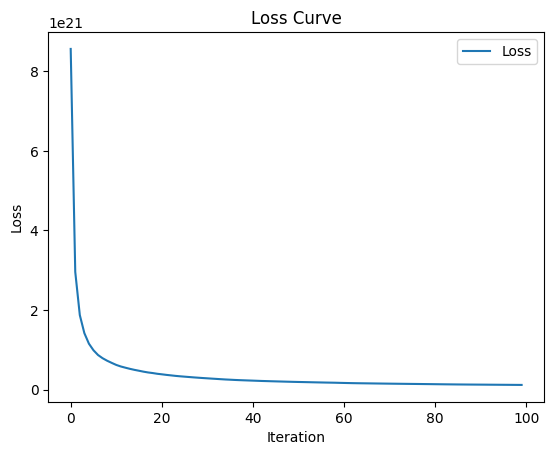

In [51]:
import matplotlib.pyplot as plt

iterations = 100
loss_curve = []  # List to store loss values

# Store our best result
best_loss, best_img = float('inf'), None

for i in range(iterations):
    print(f'iteration {i}/{iterations}:', end=' ')
    x_opt, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                          x_opt.flatten(),
                                          fprime=evaluator.grads,
                                          maxfun=20,
                                          disp=True,
                                          )
    loss_curve.append(min_val)  # Append current loss value to the curve
    print(f'Current loss: {min_val}, Best loss: {best_loss}')
    if min_val < best_loss:
        # Update best loss and best image from total loss.
        best_loss = min_val
        best_img = x_opt.copy()


# Plot the loss curve
plt.plot(loss_curve, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()


**The Final Image**

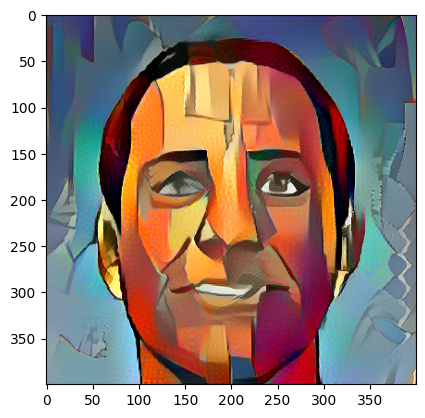

In [52]:
# save current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

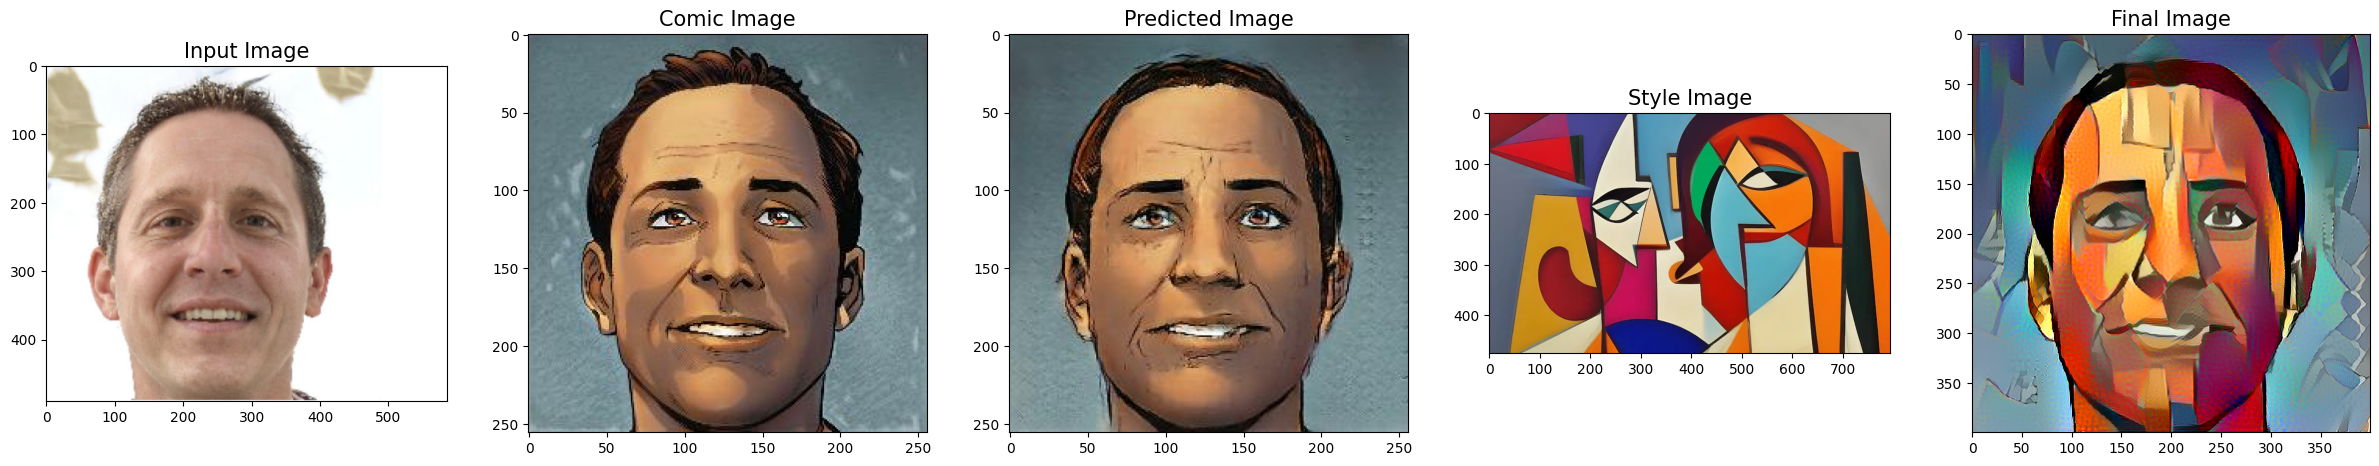

In [61]:
plt.figure(figsize=(30,30))

plt.subplot(5,5,1)
plt.title("Input Image",fontsize=15)
img_base = load_img('/content/input/input_portrait.png')
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Comic Image",fontsize=15)
img_base = load_img('/content/input/comic_image.jpg')
plt.imshow(img_base)

plt.subplot(5,5,1+2)
plt.title("Predicted Image",fontsize=15)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+3)
plt.title("Style Image",fontsize=15)
img_style = load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+4)
plt.title("Final Image",fontsize=15)
plt.imshow(imgx)
